# Analysis of Renewable Energy Investments in the U.S.

### Module Imports

In [1]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
import warnings
import numpy
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from plotnine import *

### Data imports

In [6]:
read_file = pd.read_excel ("MSN Codes.xlsx")
read_file.to_csv ("MSN Codes.csv", index = None, header=True)
read_file = pd.read_excel ("Investment_Data_Testing.xlsx")
read_file.to_csv ("Investment_Data_Testing.csv", index = None, header=True)
# read_file = pd.read_excel ("Investment_Data_2020.xlsx")
# read_file.to_csv ("Investment_Data_2020.csv", index = None, header=True)
msn_code = pd.read_csv('MSN Codes.csv')

investment_data = pd.read_csv("Investment_Data_Testing.csv")

### Data Cleaning and Preprocessing

In [34]:
single_variables = investment_data[[
    'StateCode', 'Year', 'State',
    'CO2 Emissions (Mmt)', 'TotalNumberofInvestments', 'TotalAmountofAssistance'
]].drop_duplicates()

multi_variables = investment_data[[
    'StateCode', 'Year', 'State',
    'MSN', 'Amount'
]].drop_duplicates()


MSN_feature_pivot = multi_variables.pivot(index=['StateCode', 'Year', 'State'], columns='MSN', values='Amount')

tidy_data = MSN_feature_pivot.merge(single_variables, left_on=['StateCode', 'Year'], right_on=['StateCode', 'Year'])
tidy_data_wo_na_response = tidy_data[~tidy_data['TotalAmountofAssistance'].isna()].drop(columns=['State'])

pastassistance = tidy_data_wo_na_response[['StateCode', 'Year', 'TotalAmountofAssistance']]
pastassistance['Year'] += 1
pastassistance.rename(columns={'TotalAmountofAssistance': 'pastAssistance'}, inplace=True)
tidy_data_with_pastassistance = tidy_data_wo_na_response.merge(pastassistance,  left_on=['StateCode', 'Year'], right_on=['StateCode', 'Year'])

tidy_input_data = tidy_data_with_pastassistance.drop(columns=['TotalAmountofAssistance'])
tidy_response_data = tidy_data_with_pastassistance[['StateCode', 'Year', 'TotalAmountofAssistance']]

tidy_input_data

,StateCode,Year,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,CLPRK,CLPRP,COPRK,...,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB,CO2 Emissions (Mmt),TotalNumberofInvestments,pastAssistance
0,AK,2016,27.0,5.0,27.0,5.0,13942.0,14.957,932.0,5.722,...,593662.0,0.0,7636.0,7636.0,412.0,8048.0,1563.0,33.405611,14.0,3345612.0
1,AK,2017,29.0,5.0,29.0,5.0,14365.0,14.978,959.0,5.723,...,601492.0,0.0,6501.0,6501.0,436.0,6937.0,1305.0,33.729130,18.0,2247734.0
2,AK,2018,15.0,3.0,15.0,3.0,13752.0,15.253,902.0,5.706,...,604644.0,0.0,6910.0,6910.0,456.0,7366.0,1411.0,34.514589,44.0,13509662.0
3,AK,2019,0.0,0.0,0.0,0.0,14867.0,15.252,975.0,5.698,...,605689.0,0.0,6418.0,6418.0,386.0,6803.0,1270.0,34.259440,32.0,18236626.0
4,AK,2020,0.0,0.0,0.0,0.0,15523.0,15.206,1021.0,5.691,...,640132.0,0.0,7423.0,7423.0,407.0,7831.0,1128.0,35.967527,37.0,13734021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,WY,2016,0.0,0.0,0.0,0.0,5169939.0,17.394,297218.0,5.722,...,504984.0,0.0,4357.0,4357.0,2.0,4358.0,40522.0,61.259993,23.0,249960.0
246,WY,2017,0.0,0.0,0.0,0.0,5516757.0,17.433,316454.0,5.723,...,534840.0,0.0,5049.0,5049.0,0.0,5049.0,39806.0,62.796487,47.0,1359346.0
247,WY,2018,0.0,0.0,0.0,0.0,5315953.0,17.476,304188.0,5.706,...,557604.0,0.0,4934.0,4934.0,0.0,4934.0,36936.0,63.846081,53.0,413987.0
248,WY,2019,0.0,0.0,0.0,0.0,4828513.0,17.437,276912.0,5.698,...,546671.0,0.0,4969.0,4969.0,0.0,4969.0,37070.0,59.096649,32.0,573639.0


### PCA analysis for data visualization

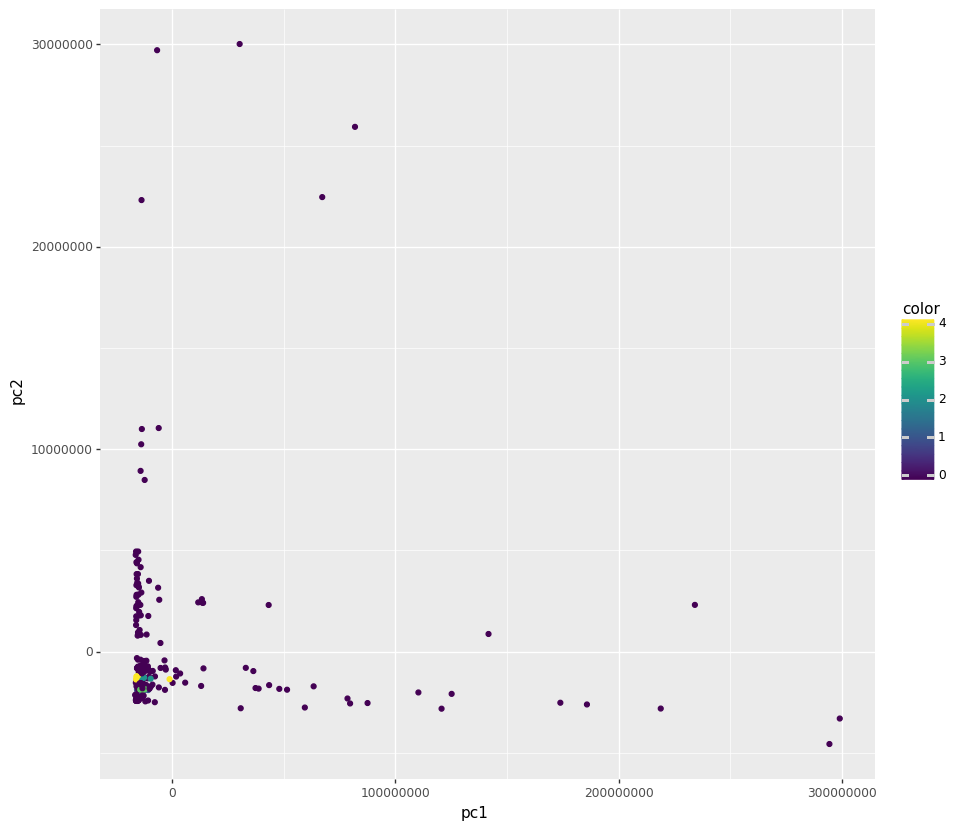

<ggplot: (378146810)>

In [36]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tidy_input_data.drop(columns=['StateCode', 'Year']))

x2d_df = pd.DataFrame(data = pca_result, columns=['pc1', 'pc2'])
x2d_df = pd.concat([tidy_input_data[['StateCode', 'Year']].reset_index(), x2d_df], axis=1)

x2d_df['color'] = 0

filterState0 = 'MA'
filterState1 = 'TN'
filterState2 = 'NE'
filterState3 = 'UT'
x2d_df.loc[
    x2d_df['StateCode']==filterState0
    ,
    'color'
] = 1
x2d_df.loc[
    x2d_df['StateCode']==filterState1
    ,
    'color'
] = 2
x2d_df.loc[
    x2d_df['StateCode']==filterState2
    ,
    'color'
] = 3
x2d_df.loc[
    x2d_df['StateCode']==filterState3
    ,
    'color'
] = 4
#x2d_df = x2d_df[x2d_df.pc1 > 0]

(ggplot(x2d_df, aes(x='pc1', y='pc2', color='color'))
  + geom_point()
  + theme(figure_size=(10, 10))
)

### Optional Filtering of MSN variables

In [11]:
# filtered_MSN_lst = []
# filtered_MSN_lst = ['REPRB', 'TETCB']
# filtered_MSN_lst = ['BFPRP', 'CLPRB', 'ENPRP', 'GETCB', 'HYTCB', 'NGMPB', 'NUETB', 'PAPRB', 'REPRB', 'SOTCB', 'TETCB', 'WWPRB', 'WYTCB']
filtered_MSN_lst = ['BDFDB', 'BDPRP', 'BFFDB', 'BFPRP', 'CLPRB',
       'CLPRK', 'CLPRP', 'COPRK', 'EMFDB', 'ENPRP', 'GETCB', 'HYTCB', 'NCPRB',
       'NGMPB', 'NGMPK', 'NGMPP', 'NUETB', 'PAPRB', 'PAPRP', 'REPRB', 'SOTCB',
       'TEPRB', 'TETCB', 'WDEXB', 'WDPRB', 'WDTCB', 'WSTCB', 'WWPRB', 'WYTCB']

corr_tidy = tidy_data_wo_na_response.corr(method = 'spearman', numeric_only=True)
corr_last3 = corr_tidy.iloc[:, -3:]
corr_last3.loc[(corr_last3['TotalAmountofAssistance'] > 0.1) ]
MSN_filtered_df = corr_tidy.iloc[:, -3:].reset_index()
MSN_filtered_df[MSN_filtered_df['index'].isin(filtered_MSN_lst)]

,index,CO2 Emissions (Mmt),TotalNumberofInvestments,TotalAmountofAssistance
1,BDFDB,0.448764,0.379818,0.281415
2,BDPRP,0.453327,0.375464,0.284464
3,BFFDB,0.411717,0.414871,0.293806
4,BFPRP,0.414695,0.411883,0.296219
5,CLPRB,0.320402,-0.013039,-0.172242
6,CLPRK,0.349326,0.003760,-0.133785
7,CLPRP,0.314836,-0.012886,-0.167603
8,COPRK,0.323508,0.152856,-0.071485
9,EMFDB,0.380828,0.364143,0.260857
10,ENPRP,0.380817,0.364047,0.260809


In [13]:
filtered_columns = ['StateCode', 'Year'] + filtered_MSN_lst + ['CO2 Emissions (Mmt)', 'TotalNumberofInvestments', 'pastAssistance']

filtered_input_data = tidy_input_data[filtered_columns]
stateCodes = filtered_input_data.StateCode.unique()
filtered_input_data

,StateCode,Year,BDFDB,BDPRP,BFFDB,BFPRP,CLPRB,CLPRK,CLPRP,COPRK,...,TETCB,WDEXB,WDPRB,WDTCB,WSTCB,WWPRB,WYTCB,CO2 Emissions (Mmt),TotalNumberofInvestments,pastAssistance
0,AK,2016,27.0,5.0,27.0,5.0,13942.0,14.957,932.0,5.722,...,593662.0,0.0,7636.0,7636.0,412.0,8048.0,1563.0,33.405611,14.0,3345612.0
1,AK,2017,29.0,5.0,29.0,5.0,14365.0,14.978,959.0,5.723,...,601492.0,0.0,6501.0,6501.0,436.0,6937.0,1305.0,33.729130,18.0,2247734.0
2,AK,2018,15.0,3.0,15.0,3.0,13752.0,15.253,902.0,5.706,...,604644.0,0.0,6910.0,6910.0,456.0,7366.0,1411.0,34.514589,44.0,13509662.0
3,AK,2019,0.0,0.0,0.0,0.0,14867.0,15.252,975.0,5.698,...,605689.0,0.0,6418.0,6418.0,386.0,6803.0,1270.0,34.259440,32.0,18236626.0
4,AK,2020,0.0,0.0,0.0,0.0,15523.0,15.206,1021.0,5.691,...,640132.0,0.0,7423.0,7423.0,407.0,7831.0,1128.0,35.967527,37.0,13734021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,WY,2016,0.0,0.0,0.0,0.0,5169939.0,17.394,297218.0,5.722,...,504984.0,0.0,4357.0,4357.0,2.0,4358.0,40522.0,61.259993,23.0,249960.0
246,WY,2017,0.0,0.0,0.0,0.0,5516757.0,17.433,316454.0,5.723,...,534840.0,0.0,5049.0,5049.0,0.0,5049.0,39806.0,62.796487,47.0,1359346.0
247,WY,2018,0.0,0.0,0.0,0.0,5315953.0,17.476,304188.0,5.706,...,557604.0,0.0,4934.0,4934.0,0.0,4934.0,36936.0,63.846081,53.0,413987.0
248,WY,2019,0.0,0.0,0.0,0.0,4828513.0,17.437,276912.0,5.698,...,546671.0,0.0,4969.0,4969.0,0.0,4969.0,37070.0,59.096649,32.0,573639.0


### Linear Regression models trained separately by state

In [25]:
"""
Separated by state
"""

X_variables = filtered_input_data#.drop(columns=['StateCode', 'Year'])
y_variables = tidy_response_data#.drop(columns=['StateCode', 'Year'])

train_X = X_variables[X_variables.Year < 2020]
train_y = y_variables[y_variables.Year < 2020]
test_X = X_variables[X_variables.Year == 2020]
compare_results = y_variables[y_variables.Year == 2020]

compare_results_total = None

for state in stateCodes:
    state_train_X = train_X[train_X['StateCode']==state].drop(columns=['StateCode', 'Year'])
    state_train_y = train_y[train_y['StateCode']==state].drop(columns=['StateCode', 'Year'])
    state_test_X = test_X[test_X['StateCode']==state].drop(columns=['StateCode', 'Year'])
    
    poly = PolynomialFeatures(1, interaction_only=False)
    poly.fit(state_train_X)
    poly_train_X = poly.transform(state_train_X)
    poly_test_X = poly.transform(state_test_X)

#     poly_train_X = state_train_X
#     poly_test_X = state_test_X
    
    scaler = StandardScaler()
    scaler.fit(poly_train_X)
    poly_train_X = scaler.transform(poly_train_X)
    poly_test_X = scaler.transform(poly_test_X)
    
    regr = ElasticNet(random_state=0, l1_ratio=0.8, alpha = 10)
    regr.fit(poly_train_X, state_train_y)
    predictions = regr.predict(poly_test_X)
    
    compare_results_poly = compare_results[compare_results['StateCode']==state]
    compare_results_poly['predict'] = predictions.tolist()
    compare_results_poly['ans_div_predict'] = compare_results_poly['TotalAmountofAssistance'] / compare_results_poly['predict']
    
    if compare_results_total is None:
        compare_results_total = compare_results_poly
    else:
        compare_results_total = pd.concat([compare_results_total, compare_results_poly])
    
print('RSME: ', sqrt(mean_squared_error(compare_results_total.predict, compare_results_total.TotalAmountofAssistance)))

compare_results_total


RSME:  210812094.25815424


,StateCode,Year,TotalAmountofAssistance,predict,ans_div_predict
4,AK,2020,9567164.0,1.894697e+07,0.504944
9,AL,2020,1174323.0,6.178335e+05,1.900711
14,AR,2020,61208016.0,1.469725e+07,4.164589
19,AZ,2020,23756565.0,4.918940e+08,0.048296
24,CA,2020,58722209.0,3.521599e+08,0.166749
29,CO,2020,6304206.0,7.288857e+06,0.864910
34,CT,2020,491729.0,9.558538e+05,0.514440
39,DE,2020,23750266.0,1.983338e+06,11.974896
44,FL,2020,8467648.0,8.601509e+07,0.098444
49,GA,2020,7307409.0,-1.510710e+07,-0.483707


### One Big Linear Regression Model

In [27]:
def predict_allstates_linear(input_data, response_data):
    print('predict_allstates_linear')
    X_variables = input_data#.drop(columns=['StateCode', 'Year'])
    y_variables = response_data#.drop(columns=['StateCode', 'Year'])

    train_X = X_variables[X_variables.Year < 2020]
    train_y = y_variables[y_variables.Year < 2020]
    test_X = X_variables[X_variables.Year == 2020]
    compare_results = y_variables[y_variables.Year == 2020]

    train_X = train_X.drop(columns=['StateCode', 'Year'])
    train_y = train_y.drop(columns=['StateCode', 'Year'])
    test_X = test_X.drop(columns=['StateCode', 'Year'])

    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)


    regr = ElasticNet(random_state=0, l1_ratio=0.2, alpha = 1)
    regr.fit(train_X, train_y)
    predictions = regr.predict(test_X)

    compare_results['predict'] = predictions.tolist()
    compare_results['ans_div_predict'] = compare_results['TotalAmountofAssistance'] / compare_results['predict']

    print('RSME: ', ((compare_results.predict - compare_results.TotalAmountofAssistance) ** 2).mean() ** .5)
    print(r2_score(compare_results['TotalAmountofAssistance'], predictions))
    return compare_results
predict_allstates_linear(filtered_input_data, tidy_response_data)

predict_allstates_linear
RSME:  28073301.161373287
0.3126036110388941


,StateCode,Year,TotalAmountofAssistance,predict,ans_div_predict
4,AK,2020,9567164.0,8.229419e+06,1.162556
9,AL,2020,1174323.0,1.718095e+07,0.068350
14,AR,2020,61208016.0,2.158717e+07,2.835388
19,AZ,2020,23756565.0,3.255529e+07,0.729730
24,CA,2020,58722209.0,8.739177e+07,0.671942
29,CO,2020,6304206.0,1.175983e+07,0.536080
34,CT,2020,491729.0,1.072249e+07,0.045860
39,DE,2020,23750266.0,1.036601e+07,2.291167
44,FL,2020,8467648.0,4.485220e+07,0.188790
49,GA,2020,7307409.0,5.115102e+07,0.142859


### One Big Polynomial (degree 2) Regression Model

In [31]:
X_variables = filtered_input_data#.drop(columns=['StateCode', 'Year'])
y_variables = tidy_response_data#.drop(columns=['StateCode', 'Year'])

train_X = X_variables[X_variables.Year < 2020]
train_y = y_variables[y_variables.Year < 2020]
test_X = X_variables[X_variables.Year == 2020]
compare_results = y_variables[y_variables.Year == 2020]

train_X = train_X.drop(columns=['StateCode', 'Year'])
train_y = train_y.drop(columns=['StateCode', 'Year'])
test_X = test_X.drop(columns=['StateCode', 'Year'])

poly = PolynomialFeatures(2, interaction_only=False)
poly.fit(train_X)
poly_train_X = poly.transform(train_X)
poly_test_X = poly.transform(test_X)

# poly_train_X = state_train_X
# poly_test_X = state_test_X

scaler = StandardScaler()
scaler.fit(poly_train_X)
poly_train_X = scaler.transform(poly_train_X)
poly_test_X = scaler.transform(poly_test_X)

regr = ElasticNet(random_state=0, l1_ratio=0.5, alpha = 1)
regr.fit(poly_train_X, train_y)
predictions = regr.predict(poly_test_X)

compare_results['predict'] = predictions.tolist()
compare_results['ans_div_predict'] = compare_results['TotalAmountofAssistance'] / compare_results['predict']

print('RSME: ', ((compare_results.predict - compare_results.TotalAmountofAssistance) ** 2).mean() ** .5)

from sklearn.metrics import r2_score
print(r2_score(compare_results['TotalAmountofAssistance'], predictions))
compare_results

RSME:  31296736.875876363
0.14568428687510704


,StateCode,Year,TotalAmountofAssistance,predict,ans_div_predict
4,AK,2020,9567164.0,8.443062e+06,1.133139
9,AL,2020,1174323.0,3.723827e+06,0.315354
14,AR,2020,61208016.0,2.471371e+07,2.476683
19,AZ,2020,23756565.0,3.365350e+07,0.705917
24,CA,2020,58722209.0,1.007232e+08,0.583006
29,CO,2020,6304206.0,9.095997e+06,0.693075
34,CT,2020,491729.0,6.393609e+06,0.076909
39,DE,2020,23750266.0,6.398006e+06,3.712135
44,FL,2020,8467648.0,6.618044e+07,0.127948
49,GA,2020,7307409.0,3.580250e+07,0.204103


### Calculating variances and determining model splits

In [37]:
past = tidy_response_data[tidy_response_data['Year'] < 2020]
current = tidy_response_data[tidy_response_data['Year'] == 2020]
means = past.groupby(by='StateCode').mean().drop(columns=['Year'])

variances = tidy_response_data.groupby(by=['StateCode']).std().drop(columns=['Year'])
variances.median().values[0]
variances['useMean'] = 0
variances.loc[
    (variances.TotalAmountofAssistance < variances.median().values[0]*0) |
    (variances.TotalAmountofAssistance > variances.median().values[0]*5)
    ,
    'useMean'
] = 1
variances

,TotalAmountofAssistance,useMean
StateCode,,
AK,5.994656e+06,0
AL,6.289690e+05,0
AR,3.579624e+07,1
AZ,4.058000e+07,1
CA,5.313078e+07,1
CO,1.173456e+07,0
CT,3.983792e+05,0
DE,1.013477e+07,0
FL,2.570955e+07,1


### Using mixed models (naive mean & Linear Regression)

In [38]:
X_variables = filtered_input_data#.drop(columns=['StateCode', 'Year'])
y_variables = tidy_response_data#.drop(columns=['StateCode', 'Year'])

train_X = X_variables[X_variables.Year < 2020]
train_y = y_variables[y_variables.Year < 2020]
test_X = X_variables[X_variables.Year == 2020]
compare_results = y_variables[y_variables.Year == 2020]

compare_results_total = None

for state in stateCodes:
    state_train_X = train_X[train_X['StateCode']==state].drop(columns=['StateCode', 'Year'])
    state_train_y = train_y[train_y['StateCode']==state].drop(columns=['StateCode', 'Year'])
    state_test_X = test_X[test_X['StateCode']==state].drop(columns=['StateCode', 'Year'])
    
    poly = PolynomialFeatures(2, interaction_only=False)
    poly.fit(state_train_X)
    poly_train_X = poly.transform(state_train_X)
    poly_test_X = poly.transform(state_test_X)

#     poly_train_X = state_train_X
#     poly_test_X = state_test_X
    
    scaler = StandardScaler()
    scaler.fit(poly_train_X)
    poly_train_X = scaler.transform(poly_train_X)
    poly_test_X = scaler.transform(poly_test_X)
    
    regr = ElasticNet(random_state=0, l1_ratio=0.3, alpha = 10)
    regr.fit(poly_train_X, state_train_y)
    predictions = regr.predict(poly_test_X)
    
    compare_results_poly = compare_results[compare_results['StateCode']==state]
    compare_results_poly['predict'] = predictions.tolist()
    
#     if variances.loc['AK', 'useMean'] == 1:
#         if compare_results_total is None:
#             compare_results_total = 
#         else:
#             compare_results_total = pd.concat([compare_results_total, compare_results_poly])
    
    if variances.loc[state, 'useMean'] == 1:
        compare_results_poly['predict'] = means.loc[state, 'TotalAmountofAssistance']
    
    if compare_results_total is None:
        compare_results_total = compare_results_poly
    else:
        compare_results_total = pd.concat([compare_results_total, compare_results_poly])

compare_results_total['ans_div_predict'] = compare_results_total['TotalAmountofAssistance'] / compare_results_total['predict']

print('RSME: ', sqrt(mean_squared_error(compare_results_total.predict, compare_results_total.TotalAmountofAssistance)))

compare_results_total

RSME:  26109645.831014004


,StateCode,Year,TotalAmountofAssistance,predict,ans_div_predict
4,AK,2020,9567164.0,1.583231e+07,0.604281
9,AL,2020,1174323.0,2.488403e+05,4.719184
14,AR,2020,61208016.0,3.667808e+07,1.668790
19,AZ,2020,23756565.0,2.486045e+07,0.955597
24,CA,2020,58722209.0,6.915048e+07,0.849195
29,CO,2020,6304206.0,1.484991e+07,0.424528
34,CT,2020,491729.0,1.123502e+06,0.437675
39,DE,2020,23750266.0,1.667749e+06,14.240911
44,FL,2020,8467648.0,2.694855e+07,0.314215
49,GA,2020,7307409.0,-9.080908e+06,-0.804700


## Conclusion
We tried many different models, but the very naive benchmark of taking the
mean of each states' Assistances from the past five years performed the best.

In [39]:
sqrt(mean_squared_error(means.TotalAmountofAssistance, current.TotalAmountofAssistance))

24183417.427109003